In [28]:
import pandas
import json, os, sys, csv
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark", rc={"axes.facecolor": (0, 0, 0, 0)})

ROOT = "/Users/kdobolyi/Documents/GitHub/hindsight2020/hindsight/paper_results/"

def format_date(date):
    if '/' not in str(date):
        return 0
    pieces = date.split("/")
    if len(pieces) != 3 or int(pieces[2]) < 20:
        return 0
    weeks = datetime.date(int("20" + pieces[2]), int(pieces[0]), int(pieces[1])).isocalendar()[1]
    if pieces[2] == "20":
        return weeks
    else:
        return weeks + 52

def cleanQ(string, questions):
    for q in questions:
        if q in string:
            return q
    
def makeChart(df_mini):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_mini, row="question_short", hue="question_short", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "week", clip_on=False,
          alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "week", clip_on=False, color="b", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "week")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.15)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
questions = ['1. Infectious Dose',
        '2. Transmissibility',
        '3. Host Range',
        '4. Incubation Period',
        '5. Clinical Presentation',
        '6. Protective Immunity',
        '7. Clinical Diagnosis',
        '8. Medical Treatments',
        '9. Vaccines',
        '10. Non-pharmaceutical Interventions (NPIs)',
        '11. Environmental Stability',
        '12. Decontamination',
        '13. PPE',
        '14. Forensics',
        '15. Genomics',
        '16. Forecasting']

df = pandas.read_csv(ROOT + "hindsight_results_combined_citations_DHSdates.csv",sep=',')
df['week'] = df['matched_date'].apply(lambda x: format_date(x))
df['question_short'] = df['question'].apply(lambda x: cleanQ(x, questions))

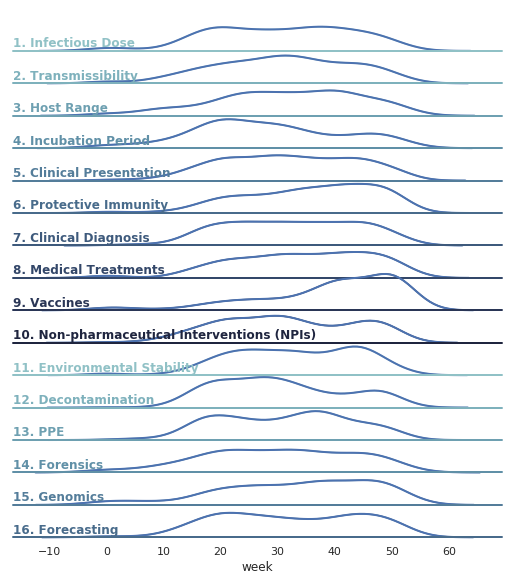

In [29]:
# show all the data in the dataframe, including nonsense matches
makeChart(df)

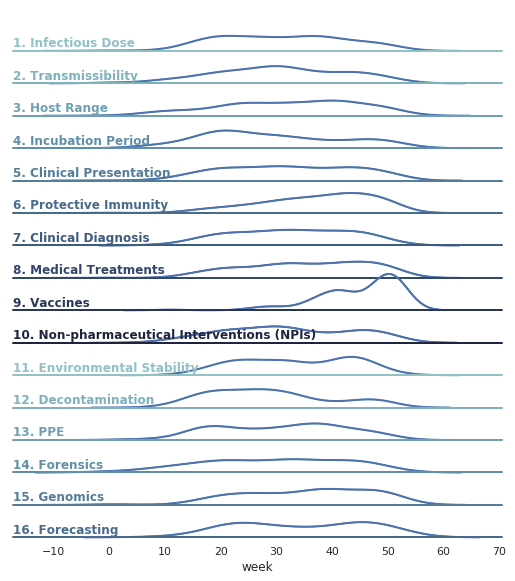

In [30]:
# show the sentences that were related to ground_truth
df_012 = df[df['score'].isin([1,0,-1,-2])]
makeChart(df_012)

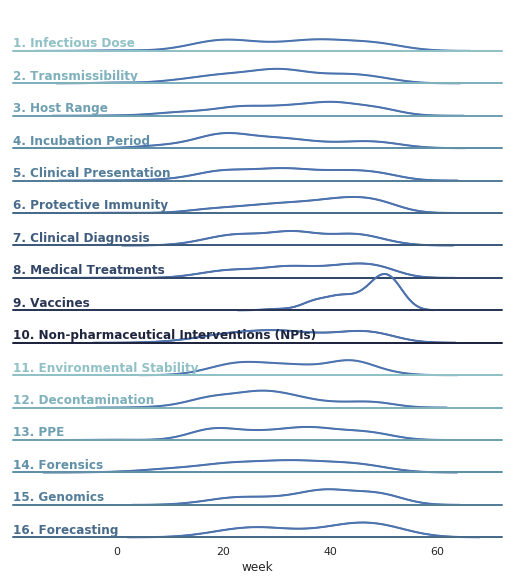

In [31]:
# show the just sentences that were strong matches to ground_truth
df_01 = df[df['score'].isin([1,0,-1])]
makeChart(df_01)

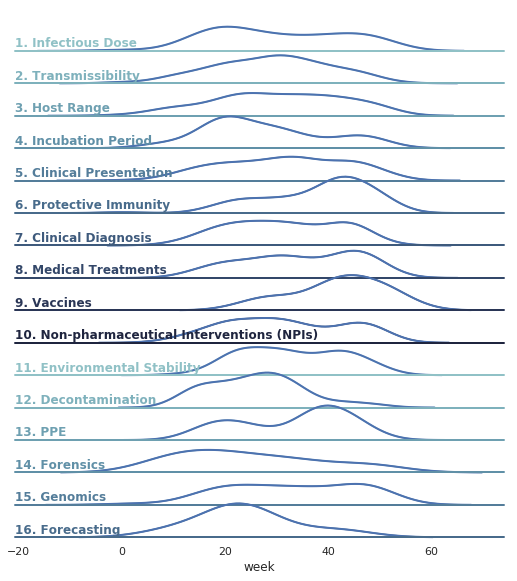

In [32]:
# show just the related sentences that represent novel research (not cited by the CORD19 papers)
df_novel_research = df[df['is_citation'] == 0.0]
df_novel_research = df_novel_research[df_novel_research['score'].isin([1,0,-1, -2])]
makeChart(df_novel_research)

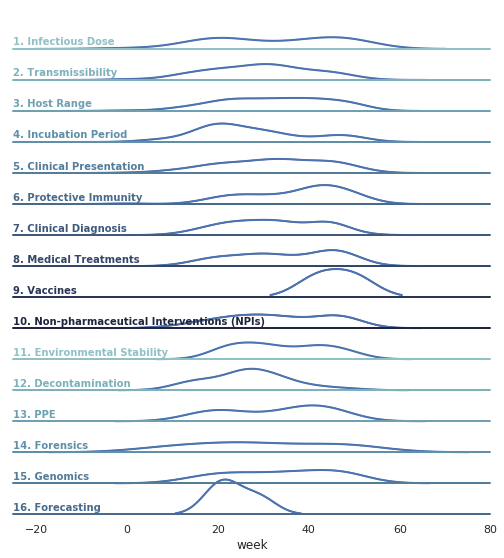

In [6]:
# show just the close matches sentences that represent novel research (not cited by the CORD19 papers)
df_novel_research = df[df['is_citation'] == 0.0]
df_novel_research = df_novel_research[df_novel_research['score'].isin([1,0,-1])]
makeChart(df_novel_research)

In [33]:
# what are the journals of the matched papers? 
# TODO: add in original journals -- are they the same, or different?
df_novel_research['matched_journal'].value_counts()

bioRxiv                                                                                                 83
medRxiv                                                                                                 33
Nat Commun                                                                                              21
Clin Infect Dis                                                                                         20
MMWR Morb Mortal Wkly Rep                                                                               18
PLoS One                                                                                                18
medRxiv : the preprint server for health sciences                                                       13
Euro Surveill                                                                                           13
Int J Infect Dis                                                                                        13
Sci Rep                              

In [34]:
# what percent of the ground truth papers (which had a known CORD19 entry) did we find the original 
# paper with STS matching?
ground_truth_IDs = {}
def mapGroundTruth(ground_truth_paperID, matched_claim_paperID, ground_truth_IDs):
    if ground_truth_paperID not in ground_truth_IDs.keys():
        ground_truth_IDs[ground_truth_paperID] = False
    if str(ground_truth_paperID) != 'nan' and matched_claim_paperID.strip() in ground_truth_paperID:
        ground_truth_IDs[ground_truth_paperID] = True
            
df[['ground_truth_paperID', 'matched_claim_paperID']].apply(lambda x: mapGroundTruth(*x, ground_truth_IDs), axis=1)

df_non_none = df[df['ground_truth_paperID'] != 'None']
citations = len(ground_truth_IDs.keys())

count = 0
#print(ground_truth_IDs)
for g in ground_truth_IDs.keys():
    if ground_truth_IDs[g] == True:
        count += 1
print(count * 100.0 / citations)

20.13201320132013


In [35]:
# what percent of the ground truth papers (which had a known CORD19 entry) were we unable to match anything at 
# all, presumably because the claim was paraphrased to the point of unrecognizability?
largestMatches = {}
def largestMatch(score, ground_truth_paperID, largestMatches):
    if ground_truth_paperID not in largestMatches.keys():
        largestMatches[ground_truth_paperID] = -3
    if score > -3:
        largestMatches[ground_truth_paperID] = 0
            
df[['score','ground_truth_paperID']].apply(lambda x: largestMatch(*x, largestMatches), axis=1)
count = 0
for k in largestMatches.keys():
    if largestMatches[k] == -3:
        count += 1
print(count * 100.0 / len(largestMatches.keys()))


4.9504950495049505


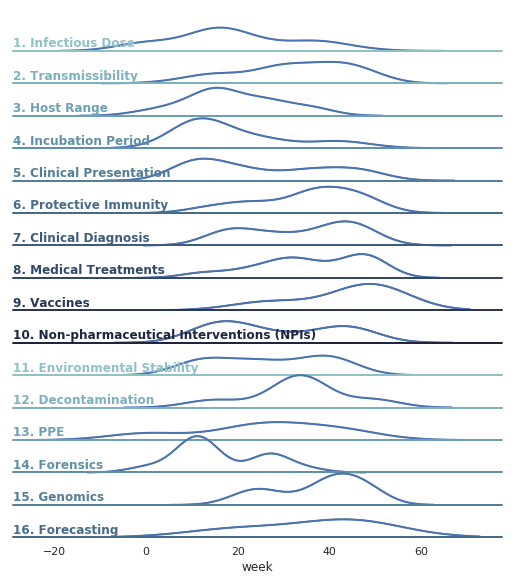

In [36]:
# what do the papers DHS cited, that are in the CORD19 dataset, look like?
dhs_citations = pandas.read_csv(ROOT + "citations_df.csv",sep=',')
dhs_citations['date'] = dhs_citations['date'].apply(lambda x: str(x))
dhs_citations['week'] = dhs_citations['date'].apply(lambda x: format_date(x))
dhs_citations['question_short'] = dhs_citations['question'].apply(lambda x: cleanQ(x, questions))
makeChart(dhs_citations)

346


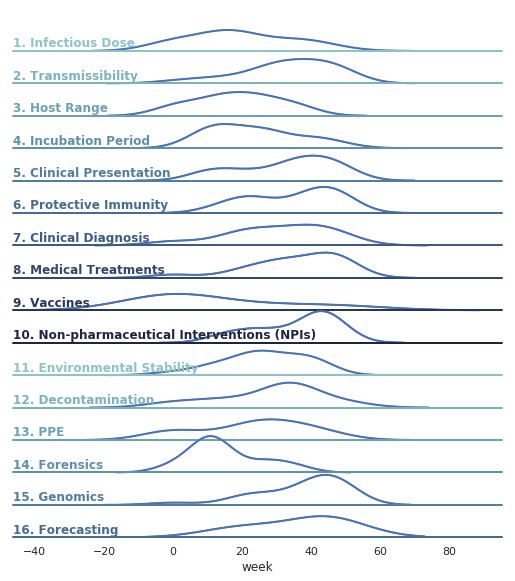

In [37]:
# number of sentences that had a CORD19 paper in our dataset
df['binary_has_ground_truth_paper'] = df['ground_truth_paperID'].apply(lambda x: 0 if len(str(x)) <10 else 1)
df_sentences_with_ground_truth_papers = df[df['binary_has_ground_truth_paper'] == 1]
df_sentences_with_ground_truth_papers = df_sentences_with_ground_truth_papers[['question','question_short','ground_truth', 'ground_truth_paper_date']]
df_sentences_with_ground_truth_papers = df_sentences_with_ground_truth_papers.drop_duplicates()
df_sentences_with_ground_truth_papers['ground_truth_paper_date'] = df_sentences_with_ground_truth_papers['ground_truth_paper_date'].apply(lambda x: str(x))
df_sentences_with_ground_truth_papers['week'] = df_sentences_with_ground_truth_papers['ground_truth_paper_date'].apply(lambda x: format_date(x))
df_sentences_with_ground_truth_papers['df_sentences_with_ground_truth_papers'] = df_sentences_with_ground_truth_papers['question'].apply(lambda x: cleanQ(x, questions))
print(len(df_sentences_with_ground_truth_papers))
makeChart(df_sentences_with_ground_truth_papers)

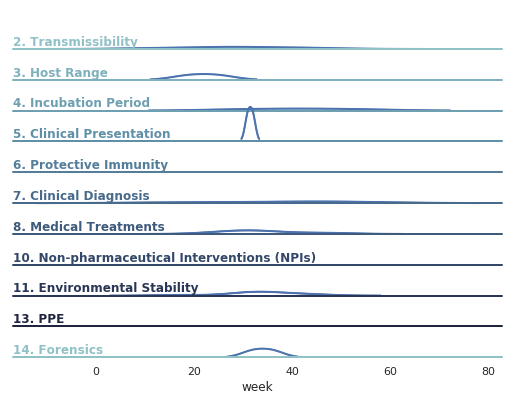

In [38]:
# show the sentence pairs where a contradiction was seen (only labelled in csv for scores >= -2)
df_contradictions = df[df['real_contradiction'] == 1]
df_contradictions = df_contradictions[df_contradictions['score'].isin([1,0,-1,-2])]
makeChart(df_contradictions)

/opt/anaconda3/envs/cell_net/lib/python3.5/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1. Infectious Dose


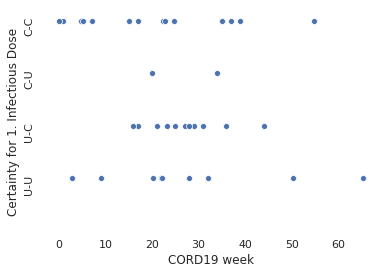

2. Transmissibility


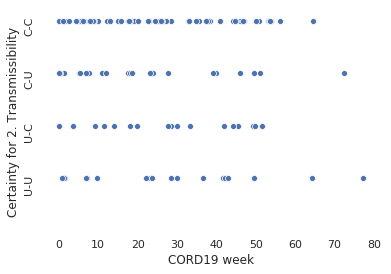

3. Host Range


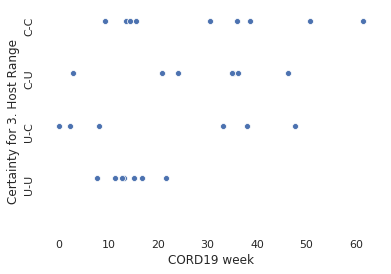

4. Incubation Period


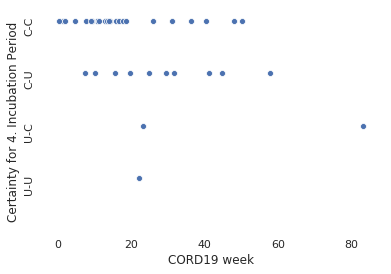

5. Clinical Presentation


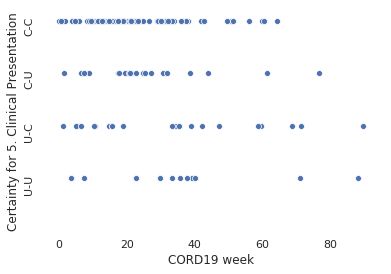

6. Protective Immunity


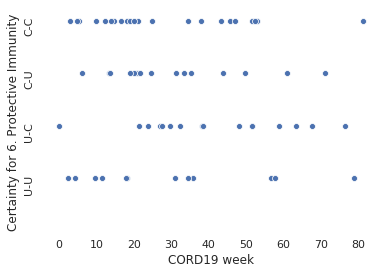

7. Clinical Diagnosis


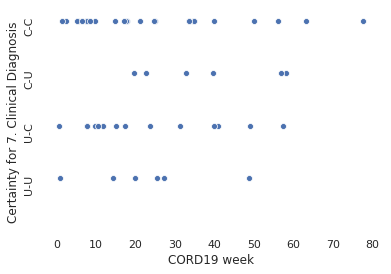

8. Medical Treatments


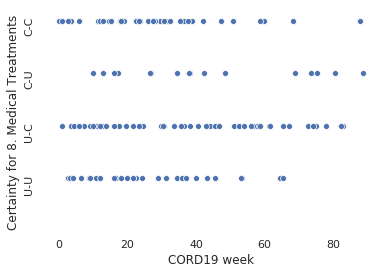

9. Vaccines


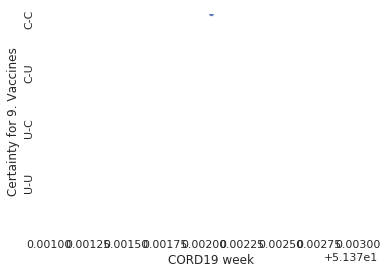

10. Non-pharmaceutical Interventions (NPIs)


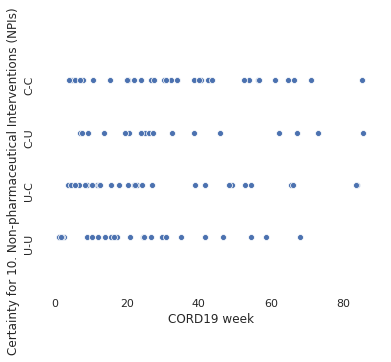

11. Environmental Stability


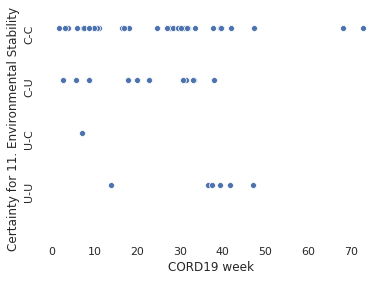

12. Decontamination


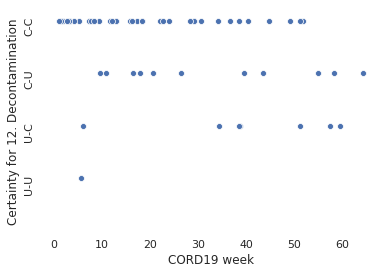

13. PPE


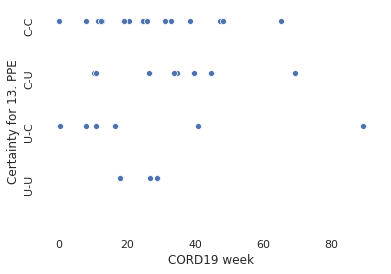

14. Forensics


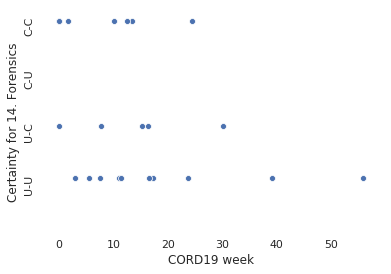

15. Genomics


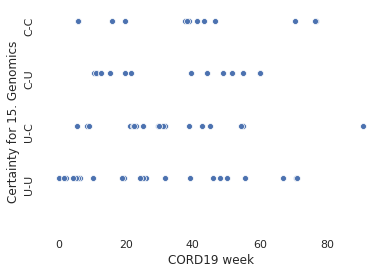

16. Forecasting


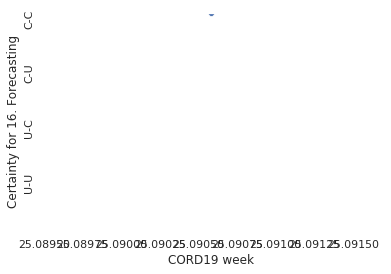

In [39]:
# TODO: visualize the hedging/uncertainty over time with lineplot
import numpy as np
import pandas as pd
import random

def processRow(question, uncertainty_old, uncertainty_new, matched_date, original_date, all_dates, rows):
    q1 = np.nan
    q2 = np.nan
    q3 = np.nan
    q4 = np.nan
    q5 = np.nan
    q6 = np.nan
    q7 = np.nan
    q8 = np.nan
    q9 = np.nan
    q10 = np.nan
    q11 = np.nan
    q12 = np.nan
    q13 = np.nan
    q14 = np.nan
    q15 = np.nan
    q16 = np.nan
    
    if uncertainty_old == 'C'and uncertainty_new == 'C':
        uncertainty = 4
    elif uncertainty_old == 'C'and uncertainty_new == 'U':
        uncertainty = 3
    elif uncertainty_old == 'U'and uncertainty_new == 'C':
        uncertainty = 2
    elif uncertainty_old == 'U'and uncertainty_new == 'U':
        uncertainty = 1
        
    if  "10." in question:
        q10 = uncertainty
    elif  "11." in question:
        q11 = uncertainty
    elif  "12." in question:
        q12 = uncertainty
    elif  "13." in question:
        q13 = uncertainty
    elif  "14." in question:
        q14 = uncertainty
    elif  "15." in question:
        q15 = uncertainty
    elif  "16." in question:
        q16 = uncertainty 
    elif "1." in question:
        q1 = uncertainty
    elif  "2." in question:
        q2 = uncertainty
    elif  "3." in question:
        q3 = uncertainty
    elif  "4." in question:
        q4 = uncertainty
    elif  "5." in question:
        q5 = uncertainty
    elif  "6." in question:
        q6 = uncertainty
    elif  "7." in question:
        q7 = uncertainty
    elif  "8." in question:
        q8 = uncertainty
    elif  "9." in question:
        q9 = uncertainty

        
    if len(str(matched_date)) < 4:
        return
    
    matched_date = format_date(matched_date)
    original_date = format_date(original_date)
    
    # if we couldn't find an original_date, the function above set it to zero
    # get rid of any sentence pairs where DHS claim comes after CORD19 claim
    if matched_date > original_date: 
        return
    
    while matched_date in all_dates and matched_date != 0:
        matched_date = matched_date * (1 + random.uniform(-0.99, 1.0))
    all_dates.append(matched_date)
    
    rows.append([matched_date, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15, q16])

all_dates = []
rows = []

df_certain_measure = df[df['score'].isin([1,0,-1,-2])]
df_certain_measure_matched = df_certain_measure[['question', 'matched_claim', 'matched_date', 'uncertainty_DHS', 'uncertainty_matched_claim', 'ground_truth_paper_date']]
df_certain_measure_matched.drop_duplicates(inplace=True)
df_certain_measure_matched = df_certain_measure_matched
ctr = len(df_certain_measure_matched)
for row in df_certain_measure_matched[['question', 'uncertainty_DHS', 'uncertainty_matched_claim', 'matched_date', 'ground_truth_paper_date']].iterrows():
    processRow(row[1]['question'], row[1]['uncertainty_DHS'], row[1]['uncertainty_matched_claim'], row[1]['matched_date'], row[1]['ground_truth_paper_date'], all_dates, rows)

data = pd.DataFrame(rows, columns=['date', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16'])
#data = data[['date', 'q3']]
#data = data.rolling(7).mean()

key = {'q1':'1. Infectious Dose',
        'q2':'2. Transmissibility',
        'q3':'3. Host Range',
        'q4':'4. Incubation Period',
        'q5':'5. Clinical Presentation',
        'q6':'6. Protective Immunity',
        'q7':'7. Clinical Diagnosis',
        'q8':'8. Medical Treatments',
        'q9':'9. Vaccines',
        'q10':'10. Non-pharmaceutical Interventions (NPIs)',
        'q11':'11. Environmental Stability',
        'q12':'12. Decontamination',
        'q13':'13. PPE',
        'q14':'14. Forensics',
        'q15':'15. Genomics',
        'q16':'16. Forecasting'}

#print(data)
for q in ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9','q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16']:
    print(key[q])
    sns.scatterplot(data=data, x='date', y=q)
    plt.xlabel("CORD19 week")
    plt.ylabel("Certainty for " + key[q])
    plt.yticks(range(5), ['','U-U','U-C', 'C-U', 'C-C'], rotation='vertical')
    plt.savefig(ROOT + "certainty_" + q + ".png")
    plt.show()
    